We import all the packages that our crawler needs to use.

In [ ]:
import re
import requests
import time
import csv
from selenium import webdriver
from bs4 import BeautifulSoup
from requests.exceptions import RequestException
import pandas as pd
import numpy as np

First we come to the top250 web page(https://www.imdb.com/chart/top), there are hyperlinks and movie names of 250 movies on this interface. So our first step is to define a function to crawl the movie's id, name, rating and generate links of the movie details page and movie review page.
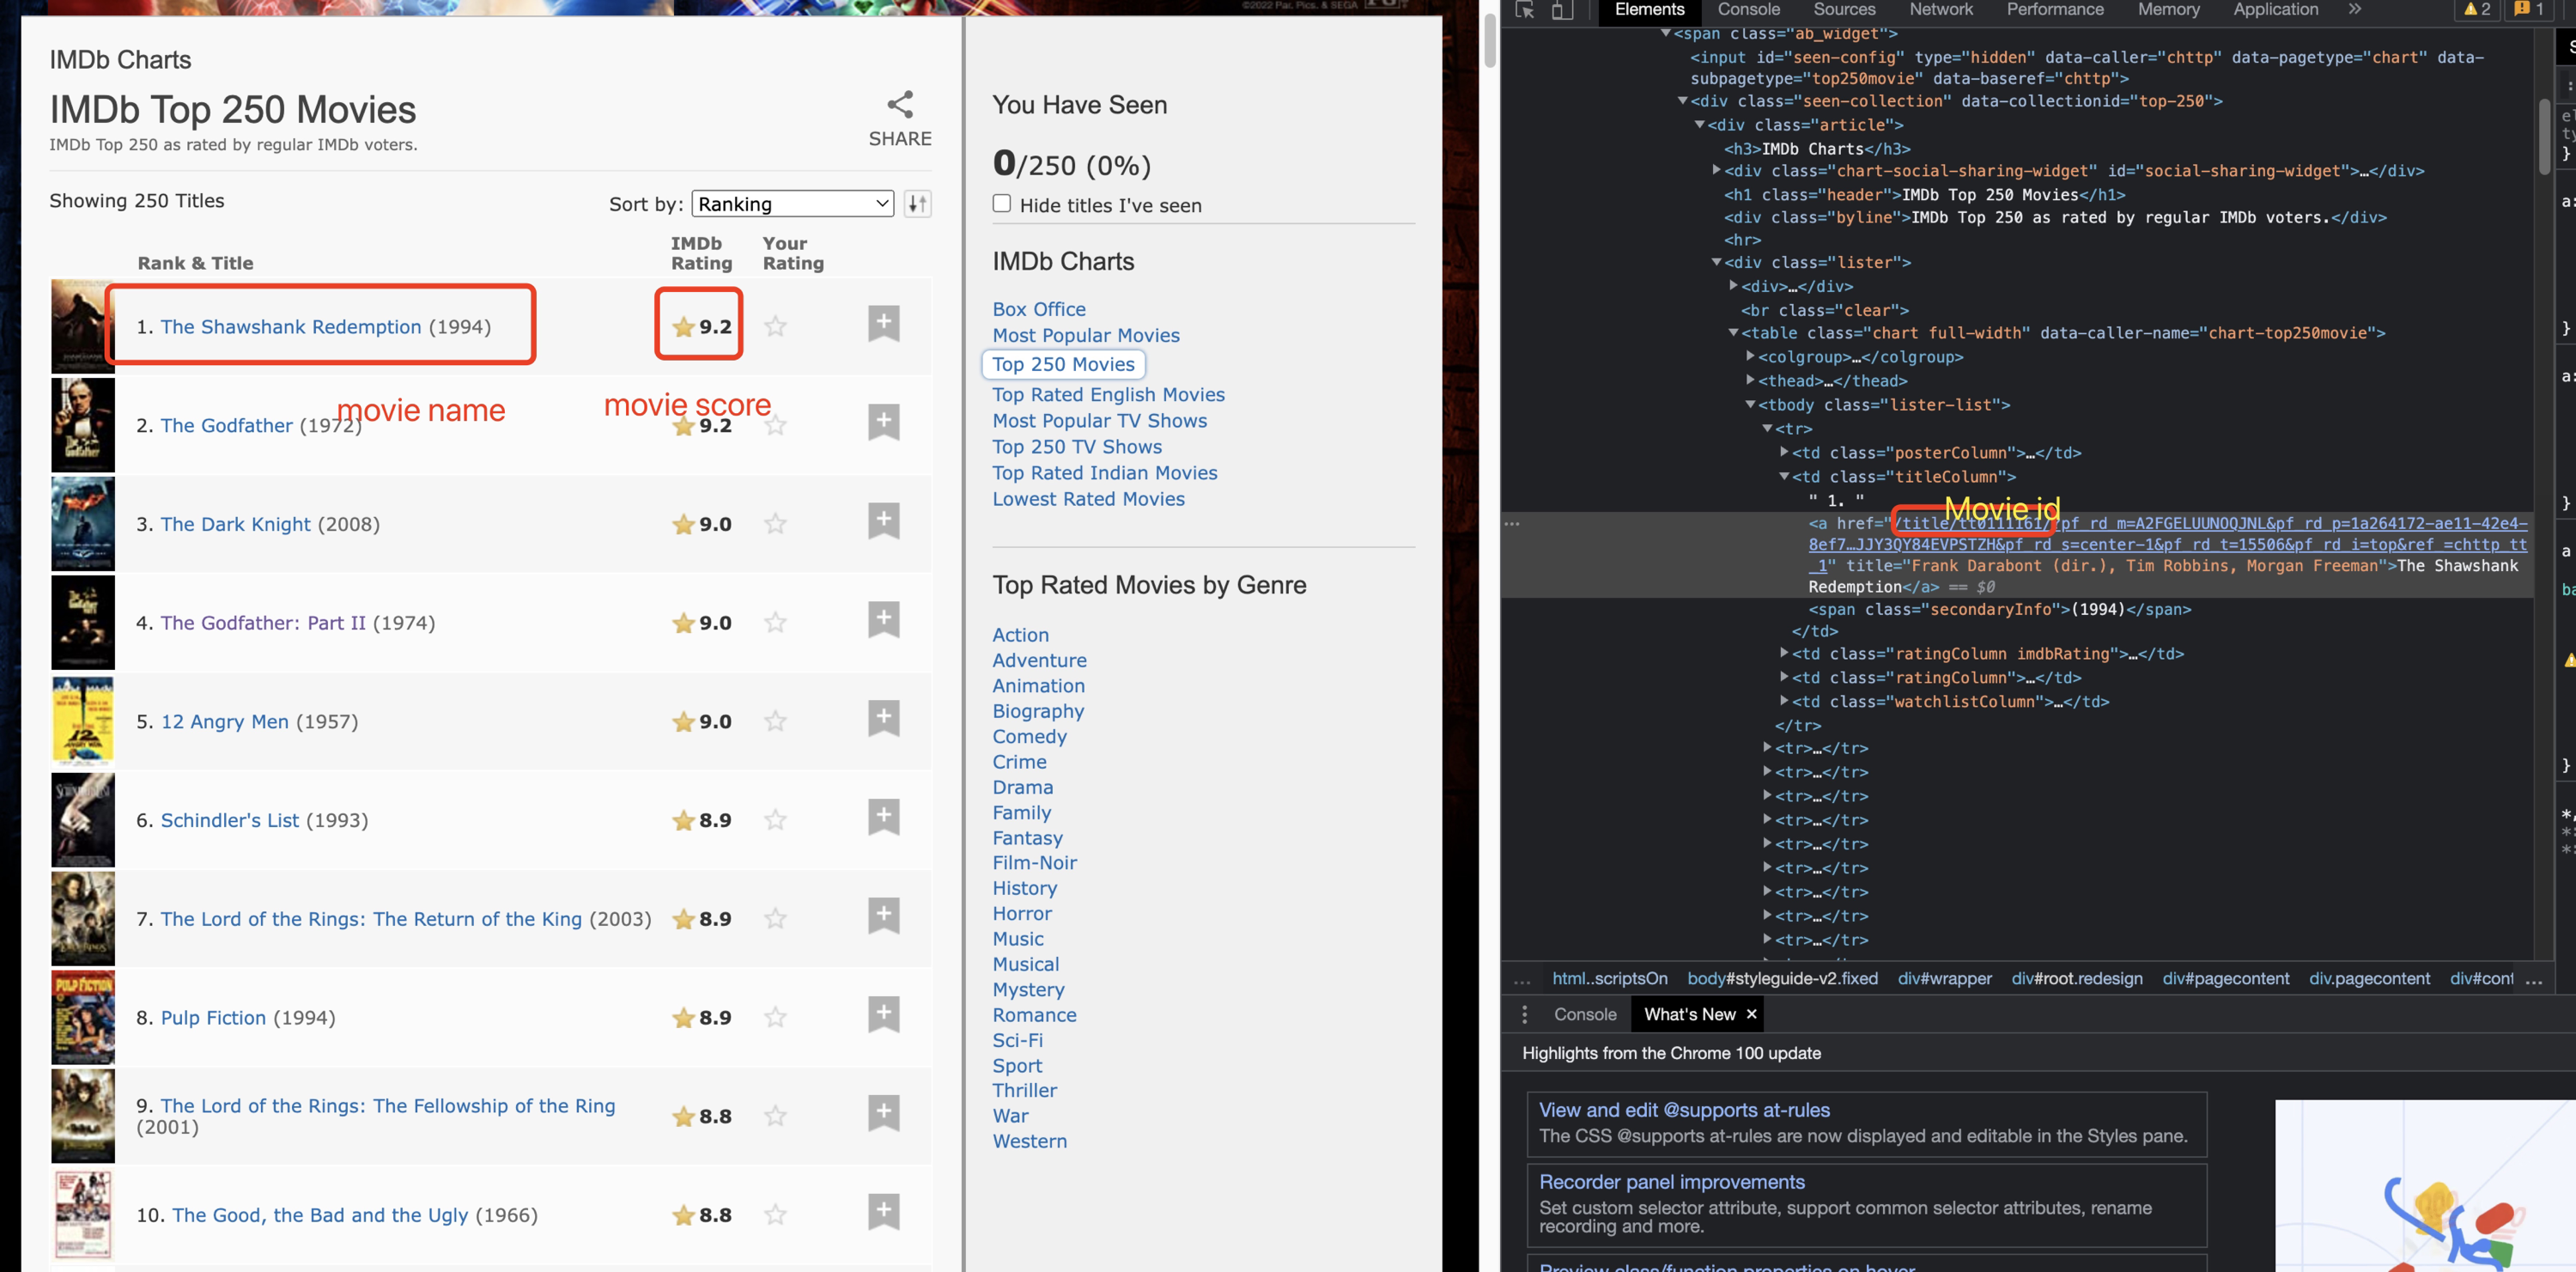

In [84]:
def generate_movie_info(url):
    response = requests.get(url)
    # Status_code 200 indicates success. 
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html,'lxml')
        # Select the corresponding movie list first.
        movies = soup.select('tbody tr')
        # Initialize the movie info list, first fill in all blanks with 0.
        movie_info_list = [[0] * 5 for j in range(250)]
        # Initialize i to fill the corresponding data to each movie
        i = 0
        for movie in movies:
            poster = movie.select_one('.posterColumn')
            # get score
            score = poster.select_one('span[name="ir"]')['data-value']
            
            # get movieId
            movie_link = movie.select_one('.titleColumn').select_one('a')['href']
            year_str = movie.select_one('.titleColumn').select_one('span').get_text()
            year_pattern = re.compile('\d{4}')
            year = int(year_pattern.search(year_str).group())
            id_pattern = re.compile(r'(?<=tt)\d+(?=/?)')
            movie_id = id_pattern.search(movie_link).group()
            
            # get movieName
            movie_name = movie.select_one('.titleColumn').select_one('a').string
            
            # Generate movieUrl
            movie_url = "https://www.imdb.com/title/"+str(movie_id)+"/?ref_=tt_urv"
            
            # Generate movieReviewUrl
            movie_reviews_url = \
            "https://www.imdb.com/title/tt"+str(movie_id)+"/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0"
            
            # Append all the information into final list
            movie_info_list[i] = [movie_id, movie_name, score, movie_url, movie_reviews_url]
            
            i += 1

    return movie_info_list

# Top250 movie url and transform into dataframe
url = 'https://www.imdb.com/chart/top'
movie_info_list = generate_movie_info(url)
Top250 = pd.DataFrame(movie_info_list, columns =['movieId', 'movieName', 'movieScore', \
                                                        'movieLink', 'movieReviewLink'])
# Export into csv file
Top250.to_csv('top_movie_list.csv')

# Data Display
Top250

,movieId,movieName,movieScore,movieLink,movieReviewLink
0,0111161,The Shawshank Redemption,9.240109237945433,https://www.imdb.com/title/0111161/?ref_=tt_urv,https://www.imdb.com/title/tt0111161/reviews?s...
1,0068646,The Godfather,9.161289887364756,https://www.imdb.com/title/0068646/?ref_=tt_urv,https://www.imdb.com/title/tt0068646/reviews?s...
2,0468569,The Dark Knight,8.99457239775514,https://www.imdb.com/title/0468569/?ref_=tt_urv,https://www.imdb.com/title/tt0468569/reviews?s...
3,0071562,The Godfather: Part II,8.99033695773171,https://www.imdb.com/title/0071562/?ref_=tt_urv,https://www.imdb.com/title/tt0071562/reviews?s...
4,0050083,12 Angry Men,8.950992808370717,https://www.imdb.com/title/0050083/?ref_=tt_urv,https://www.imdb.com/title/tt0050083/reviews?s...
...,...,...,...,...,...
245,0083987,Gandhi,8.014990192724705,https://www.imdb.com/title/0083987/?ref_=tt_urv,https://www.imdb.com/title/tt0083987/reviews?s...
246,1160419,Dune,8.014747195805084,https://www.imdb.com/title/1160419/?ref_=tt_urv,https://www.imdb.com/title/tt1160419/reviews?s...
247,1454029,The Help,8.014193017821958,https://www.imdb.com/title/1454029/?ref_=tt_urv,https://www.imdb.com/title/tt1454029/reviews?s...
248,4016934,The Handmaiden,8.01298448784217,https://www.imdb.com/title/4016934/?ref_=tt_urv,https://www.imdb.com/title/tt4016934/reviews?s...


Loading comments on the desired comment page requires clicking the load more button to do so. Since we crawl 100 reviews for each movie this time, we only need to click three times to load, and then crawl the reviews on the page, and we also crawl the title, user ID, and date of the review. For some movies with less than 100 reviews, if the load more button is not visible, stop clicking immediately.

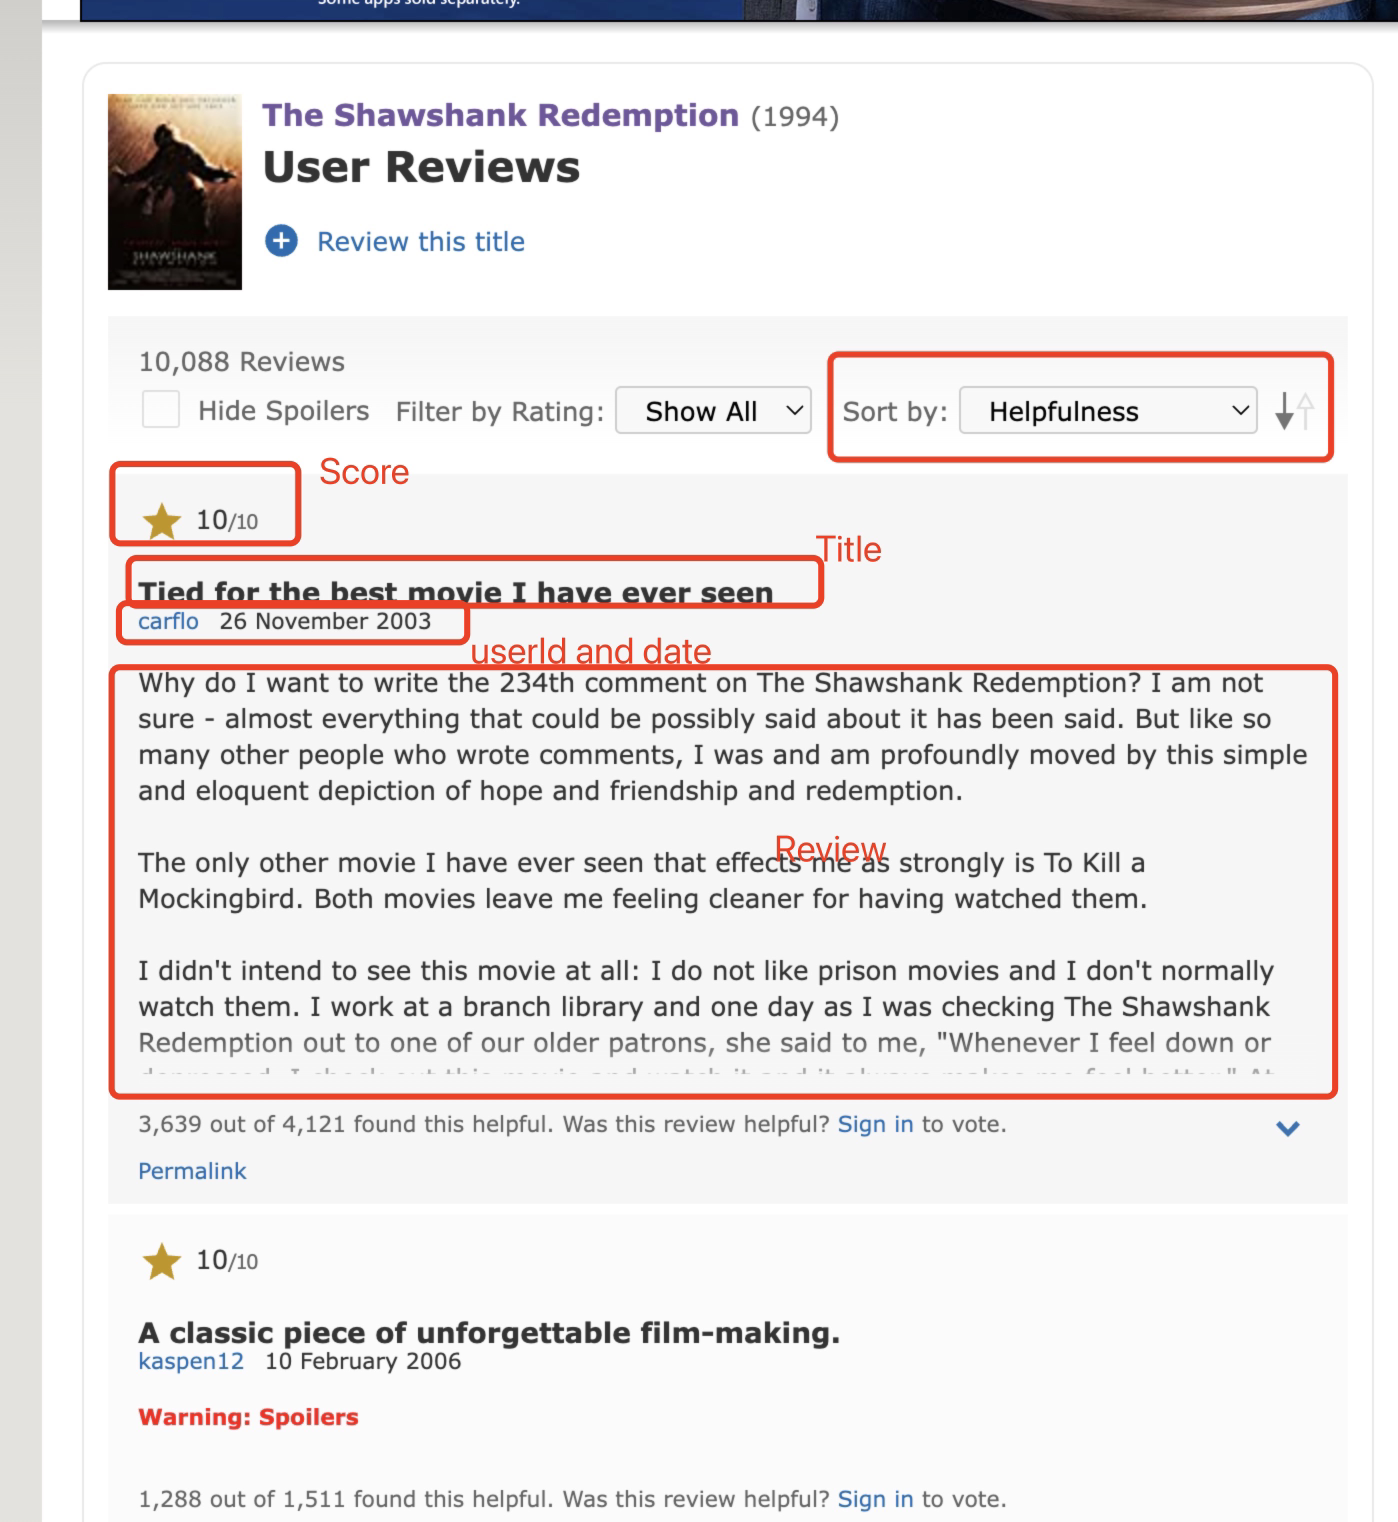


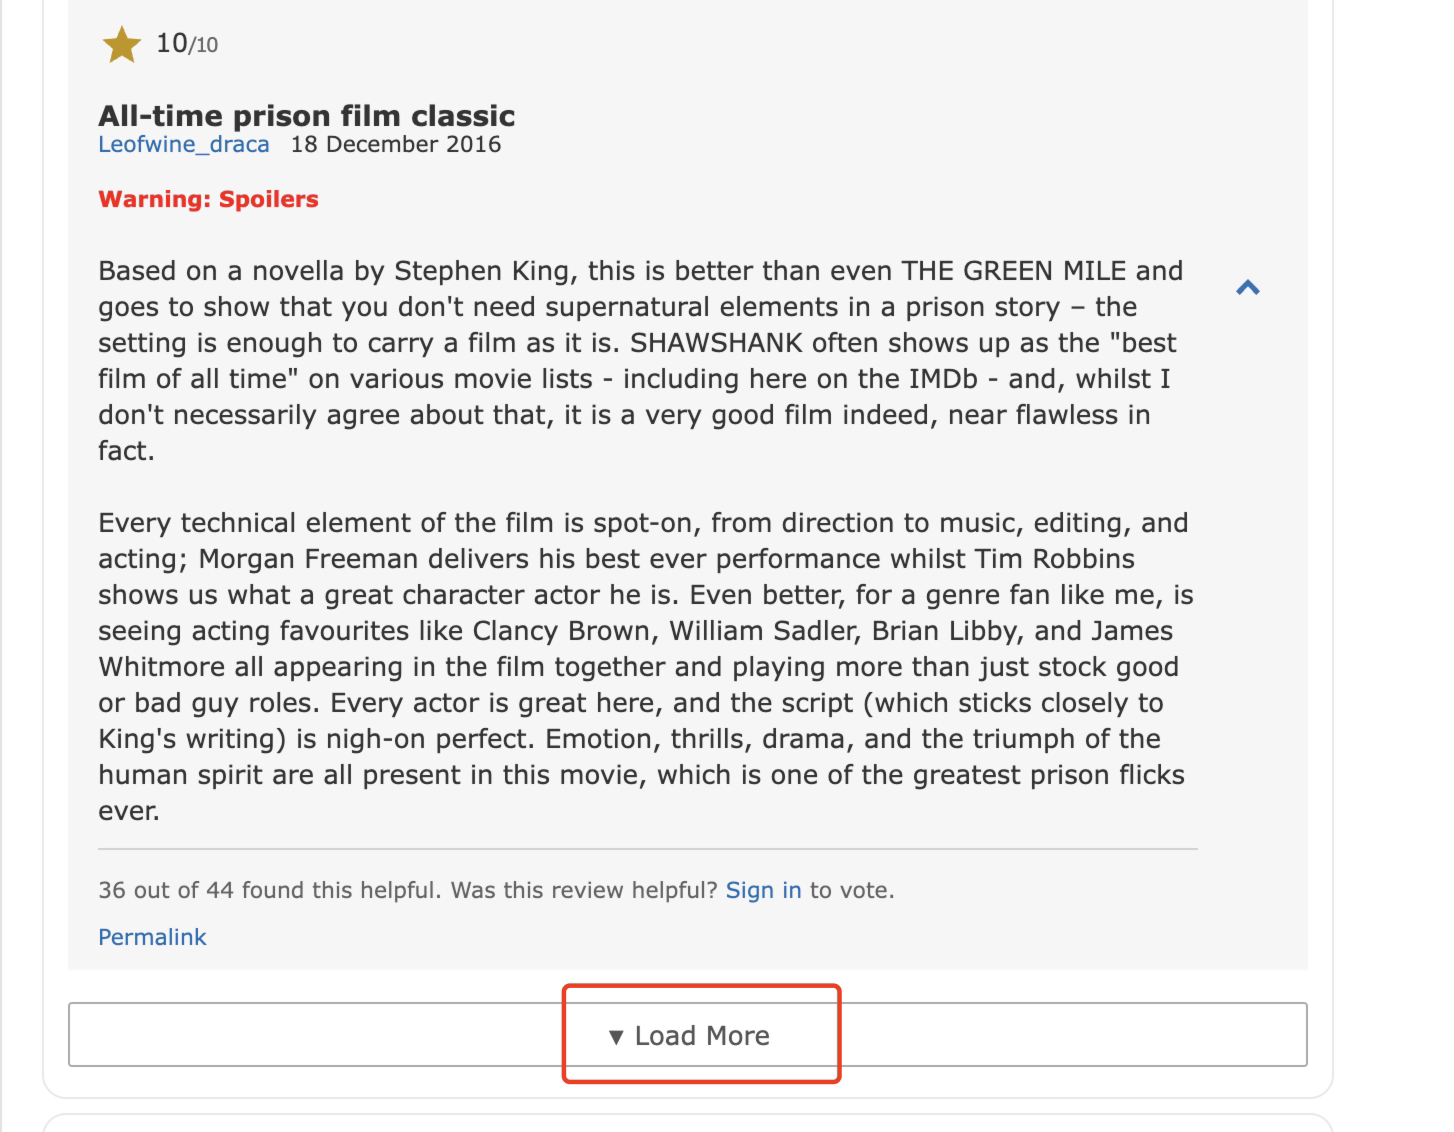

In [64]:
# Same function as above, but we only return the review link and movie id for further use.
def generate_movie_review_list_link(url):
    # Set exception if fail to request.
    try:
        response = requests.get(url)
        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'lxml')
            movies = soup.select('tbody tr')
            movie_reviews_url_list = [[0] * 2 for j in range(250)]
            i = 0
            for movie in movies:
                poster = movie.select_one('.posterColumn')
                score = poster.select_one('span[name="ir"]')['data-value']
                movie_link = movie.select_one('.titleColumn').select_one('a')['href']
                year_str = movie.select_one('.titleColumn').select_one('span').get_text()
                year_pattern = re.compile('\d{4}')
                year = int(year_pattern.search(year_str).group())
                id_pattern = re.compile(r'(?<=tt)\d+(?=/?)')
                movie_id = (id_pattern.search(movie_link).group())
                movie_name = movie.select_one('.titleColumn').select_one('a').string
                movie_reviews_url = "https://www.imdb.com/title/tt"+str(movie_id)+"/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0"
                # Only return the id and reviewsUrl
                movie_reviews_url_list[i] = [movie_id,movie_reviews_url]
                i += 1
            return movie_reviews_url_list
        else:
            print("Error when request URL")
    except RequestException:
        print("Request Failed")
        return None

# 
def get_imdb_movie_review(url,movieId):
    # The network status.
    NETWORK_STATUS = True 
    
    # print url
    print(url)
    # Set exception if fail to request.
    try:
        response = requests.get(url)
        # Status_code 200 indicates success.
        if response.status_code == 200:
            original_html = response.text

            original_soup = BeautifulSoup(original_html,'lxml')
            # Can also use chrome, driver = webdriver.Chrome("")
            driver = webdriver.Safari()
            driver.get(url)
            
            # Set count for click 'load more' button
            load_count = 0
            while(load_count < 3):
                temp_response = driver.page_source
                temp_html = temp_response
                temp_soup = BeautifulSoup(temp_html,'lxml')
                load_more = temp_soup.select('.ipl-load-more__button')
                button_load_more = driver.find_element_by_class_name('ipl-load-more__button')
                if(len(load_more) == 1):
                    button_is_or_not_visible = driver.find_element_by_class_name('ipl-load-more__button').is_displayed()
                    # Stop clicking when the button is not visible
                    if(button_is_or_not_visible is True):       
                        button_load_more.click()
                        load_count += 1
                        time.sleep(2)
                    else:
                        break
                else:
                    break

            final_response = driver.page_source
            html = final_response
            soup = BeautifulSoup(html,'lxml')
            movie_id = movieId
            # Select the corresponding movie list first.
            reviews = soup.select('.review-container')
            # Initialize the movie info list, first fill in all blanks with 0.
            movie_reviews_list = [[0] * 6 for j in range(1500)]
            # Initialize i to fill the corresponding data to each movie
            i = 0
            for review in reviews:
                header = review.select_one('.display-name-date')
                user_link = header.select_one('a')['href']
                user_id_pattern = re.compile(r'(?<=ur)\d+(?=/?)')
                # get userId
                user_id = int(user_id_pattern.search(user_link).group())  
                # get reviewDate
                review_date = header.select_one('.review-date').string      

                content = review.select_one('.content')
                # get reviewScore, reviewTitle, userReview
                review_score = review.select('div.lister-item-content div.ipl-ratings-bar span span:nth-child(2)')
                review_title = review.select('div.lister-item-content a')
                user_review = content.select('.text.show-more__control')   
                
                # Append all the information into final list
                movie_reviews_list[i][0] = user_id
                movie_reviews_list[i][1] = review_date
                movie_reviews_list[i][2] = review_score
                movie_reviews_list[i][3] = review_title
                movie_reviews_list[i][4] = user_review
                movie_reviews_list[i][5] = movie_id

                i += 1
                time.sleep(0.01)
            # Close the driver
            driver.close()     
            return movie_reviews_list
        else:
            print("Error when request URL")
    except RequestException:
        print("Request Failed")
        return None
    except requests.exceptions.Timeout:
        #Request timed out
        NETWORK_STATUS = False  
        if NETWORK_STATUS == False:
            # Close the driver
            driver.close()  
            print('Request timed out, repeat request')
            get_imdb_movie_review(url, movieId)

if __name__ == '__main__':
    # Write the document into csv file.
    count = 0
    with open('movie_review_info.csv', 'w', newline="",encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile, dialect=("excel"))
        csvwriter.writerow(["userId", "reviewDate", "reviewScore", "reviewTitle", "userReview","movieId"])
        movie_list_url = 'https://www.imdb.com/chart/top'
        movie_review_url_list = generate_movie_review_list_link(movie_list_url)
        j = 0
        while (j < 250):
            print("Movie" + str(j + 1) + "Review")
            l = [[0] * 6 for j in range(250)]
            l = get_imdb_movie_review(movie_review_url_list[j][1], movie_review_url_list[j][0])
            k = 0
            if(l is None):
                j += 1
                continue

            while(l[k][0] != 0):
                csvwriter.writerow(l[k])
                k += 1
                count += 1
            j += 1

    print("Over, the total count of reviews is" + str(count))

第1部电影的评论
https://www.imdb.com/title/tt0111161/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0


<ipython-input-64-7cb98d3d4fb8>:61: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  button_load_more = driver.find_element_by_class_name('ipl-load-more__button')
<ipython-input-64-7cb98d3d4fb8>:63: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  button_is_or_not_visible = driver.find_element_by_class_name('ipl-load-more__button').is_displayed()


第2部电影的评论
https://www.imdb.com/title/tt0068646/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第3部电影的评论
https://www.imdb.com/title/tt0468569/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第4部电影的评论
https://www.imdb.com/title/tt0071562/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第5部电影的评论
https://www.imdb.com/title/tt0050083/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第6部电影的评论
https://www.imdb.com/title/tt0108052/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第7部电影的评论
https://www.imdb.com/title/tt0167260/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第8部电影的评论
https://www.imdb.com/title/tt0110912/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第9部电影的评论
https://www.imdb.com/title/tt0120737/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第10部电影的评论
https://www.imdb.com/title/tt0060196/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第11部电影的评论
https://www.imdb.com/title/tt0109830/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=

第84部电影的评论
https://www.imdb.com/title/tt0180093/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第85部电影的评论
https://www.imdb.com/title/tt1187043/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第86部电影的评论
https://www.imdb.com/title/tt5311514/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第87部电影的评论
https://www.imdb.com/title/tt0045152/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第88部电影的评论
https://www.imdb.com/title/tt0086190/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第89部电影的评论
https://www.imdb.com/title/tt0105236/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第90部电影的评论
https://www.imdb.com/title/tt0338013/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第91部电影的评论
https://www.imdb.com/title/tt0062622/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第92部电影的评论
https://www.imdb.com/title/tt0057565/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第93部电影的评论
https://www.imdb.com/title/tt0033467/reviews?sort=helpfulnessScore&dir=desc&ratin

第165部电影的评论
https://www.imdb.com/title/tt0050212/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第166部电影的评论
https://www.imdb.com/title/tt0117951/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第167部电影的评论
https://www.imdb.com/title/tt5027774/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第168部电影的评论
https://www.imdb.com/title/tt1291584/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第169部电影的评论
https://www.imdb.com/title/tt1205489/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第170部电影的评论
https://www.imdb.com/title/tt0116282/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第171部电影的评论
https://www.imdb.com/title/tt0096283/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第172部电影的评论
https://www.imdb.com/title/tt1392214/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第173部电影的评论
https://www.imdb.com/title/tt0405159/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第174部电影的评论
https://www.imdb.com/title/tt0083658/reviews?sort=helpfulnessScore&dir=

第246部电影的评论
https://www.imdb.com/title/tt1160419/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第247部电影的评论
https://www.imdb.com/title/tt0083987/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第248部电影的评论
https://www.imdb.com/title/tt1454029/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第249部电影的评论
https://www.imdb.com/title/tt4016934/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
第250部电影的评论
https://www.imdb.com/title/tt0099348/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=0
爬虫完毕，共爬取24188个用户评论
